## Comparison AI model and CTG readout

In this notebook we want to comapre the results obtained with the AI detectio model, the CTG read out scans and the manually annotated images. Todo

In [19]:
import os
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
import pickle
from tqdm import tqdm

import os
import torch
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from scipy.stats import pearsonr, spearmanr

from src.utils.data_utils import run_length_encode
from src.model.dataset import InferenceMaskRCNNDataset, MaskRCNNDataset
from src.model.engine import FitterMaskRCNN
from src.model.model import maskRCNNModel
from src.utils.data_utils import masks_to_area, mask_to_eccentricity, masks_to_volume, masks_to_volume_2, masks_to_diameter
from src.utils.utils import load_finetuned_weights, load_pretrained_weights

dataset_path_d131="/Users/francesco/Documents/Work/Colorectal-Cancer-Organoids-Detection/dataset/full_experiment/D131_DMSO_d10"
dataset_path_d223="/Users/francesco/Documents/Work/Colorectal-Cancer-Organoids-Detection/dataset/full_experiment/D223_DMSO_d10"
dataset_path_d284="/Users/francesco/Documents/Work/Colorectal-Cancer-Organoids-Detection/dataset/full_experiment/D284_DMSO_d10"
train_dataset_path = "/Users/francesco/Documents/Work/Colorectal-Cancer-Organoids-Detection/dataset/train"
val_dataset_path = "/Users/francesco/Documents/Work/Colorectal-Cancer-Organoids-Detection/dataset/val"
CTG_files = []
confidence = [0, 0.5, 0.75, 0.9]


In [20]:
# # run the inference on the dataset
# dataset_inference_d131 = InferenceMaskRCNNDataset(dataset_path_d131)
# loader_d131 = DataLoader(dataset_inference_d131, batch_size=4, shuffle=False, collate_fn = lambda x: tuple(zip(*x)))
# print(f"Loaded {len(dataset_inference_d131)} images from {dataset_inference_d131}")
dataset_inference_d223 = InferenceMaskRCNNDataset(dataset_path_d223)
loader_d223 = DataLoader(dataset_inference_d223, batch_size=4, shuffle=False, collate_fn = lambda x: tuple(zip(*x)))
print(f"Loaded {len(dataset_inference_d223)} images from {dataset_inference_d223}")
dataset_inference_d284 = InferenceMaskRCNNDataset(dataset_path_d284)
loader_d284 = DataLoader(dataset_inference_d284, batch_size=4, shuffle=False, collate_fn = lambda x: tuple(zip(*x)))
print(f"Loaded {len(dataset_inference_d284)} images from {dataset_inference_d284}")
# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# initialize pretrained model
model_p = maskRCNNModel()
weights = load_pretrained_weights(device)
model_p.load_state_dict(weights)
model_p.to(device)
# initialize finetuned model
model_f = maskRCNNModel()
weights = load_finetuned_weights(device)
model_f.load_state_dict(weights)
model_f.to(device)


Loaded 384 images from <src.model.dataset.InferenceMaskRCNNDataset object at 0x317a4f440>
Loaded 384 images from <src.model.dataset.InferenceMaskRCNNDataset object at 0x312cb78f0>


/Users/francesco/Documents/Work/Colorectal-Cancer-Organoids-Detection/src/utils/utils.py:156: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_wei

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(

predict the images, process the predicitons for our scope and store the infor

In [21]:
def process_predictions(output):
    processed = pd.DataFrame(columns=["confidence", "area", "volume", "diameter", "x1", "y1", "x2", "y2"])
    for box, mask, score in zip(output["boxes"], output["masks"], output["scores"]):
        mask = (mask > 0.5).type(torch.uint8)
        diameter = masks_to_diameter(mask)
        area = masks_to_area(mask)
        volume = masks_to_volume(mask)
        x1, y1, x2, y2 = box
        processed.loc[len(processed)] = [score.item(), area, volume, diameter, x1, y1, x2, y2]
    return processed

def predict_dataset(loader, model, device):
    model.eval()
    processed_predictions = {}
    with torch.no_grad():
        for images, metadata in tqdm(loader):
            images = [img.to(device) for img in images]
            predictions = model(images)
            for p, m in zip(predictions, metadata):
                processed_predictions[m["path"]] = process_predictions(p)
    return processed_predictions

# predictions_path_d131 = "full_experiment/predictions_d131.pkl"
# if os.path.exists(predictions_path_d131):
#     with open(predictions_path_d131, "rb") as f:
#         processed_predictions = pickle.load(f)
# else:
#     os.makedirs(os.path.dirname(predictions_path_d131), exist_ok=True)
#     processed_predictions = predict_dataset(loader_d131, model, device)
#     with open(predictions_path_d131, "wb") as f:
#         pickle.dump(processed_predictions, f)d

predictions_path_d223_p = "full_experiment/predictions_d223_pretrained.pkl"
if os.path.exists(predictions_path_d223_p):
    with open(predictions_path_d223_p, "rb") as f:
        processed_predictions_d223_p = pickle.load(f)
else:
    os.makedirs(os.path.dirname(predictions_path_d223_p), exist_ok=True)
    processed_predictions_d223_p = predict_dataset(loader_d223, model_p, device)
    with open(predictions_path_d223_p, "wb") as f:
        pickle.dump(processed_predictions_d223_p, f)

predictions_path_d284_p = "full_experiment/predictions_d284_pretrained.pkl"
if os.path.exists(predictions_path_d284_p):
    with open(predictions_path_d284_p, "rb") as f:
        processed_predictions_d284_p = pickle.load(f)
else:
    os.makedirs(os.path.dirname(predictions_path_d284_p), exist_ok=True)
    processed_predictions_d284_p = predict_dataset(loader_d284, model_p, device)
    with open(predictions_path_d284_p, "wb") as f:
        pickle.dump(processed_predictions_d284_p, f)

predictions_path_d223_f = "full_experiment/predictions_d223_finetuned.pkl"
if os.path.exists(predictions_path_d223_f):
    with open(predictions_path_d223_f, "rb") as f:
        processed_predictions_d223_f = pickle.load(f)
else:
    os.makedirs(os.path.dirname(predictions_path_d223_f), exist_ok=True)
    processed_predictions_d223_f = predict_dataset(loader_d223, model_f, device)
    with open(predictions_path_d223_f, "wb") as f:
        pickle.dump(processed_predictions_d223_f, f)

predictions_path_d284_f = "full_experiment/predictions_d284_finetuned.pkl"
if os.path.exists(predictions_path_d284_f):
    with open(predictions_path_d284_f, "rb") as f:
        processed_predictions_d284_f = pickle.load(f)
else:
    os.makedirs(os.path.dirname(predictions_path_d284_f), exist_ok=True)
    processed_predictions_d284_f = predict_dataset(loader_d284, model_f, device)
    with open(predictions_path_d284_f, "wb") as f:
        pickle.dump(processed_predictions_d284_f, f)



## CTG dataset

the order of images is tha same order as in the dictionary above

In [22]:
# read CTG files
columns = ["ID", "well", "CTG"]
CTG_D223_DMSO = pd.read_csv("CTG_reatout/15042024_TM_M3_DTP1_D223_DMSO.txt", names=columns, sep="\t")
CTG_D284_DMSO = pd.read_csv("CTG_reatout/15042024_TM_M3_DTP1_D284_DMSO.txt", names=columns, sep="\t")


In [23]:
def get_ctg_readout(processed_predictions, ctg_df):
    ctg_values = []
    for image_path in processed_predictions.keys():
        # get the well name
        well_nr = int(os.path.basename(image_path).split("_")[1][2:])
        well_row = chr(ord('A') + (well_nr-1)//24)
        well_col = ((well_nr-1) % 24) + 1
        well_name = f"{well_row}{well_col:02d}"
        ctg_value = ctg_df[ctg_df["well"] == well_name]["CTG"].values[0]
        ctg_values.append(ctg_value)
    return ctg_values

# ctg_values_d131 = get_ctg_readout(processed_predictions, ctg_df_d131)
ctg_values_d223 = get_ctg_readout(processed_predictions_d223_f, CTG_D223_DMSO)
ctg_values_d284 = get_ctg_readout(processed_predictions_d284_f, CTG_D284_DMSO)


## Plots

In [50]:
import seaborn as sns

def get_features(processed_predictions, conf_threshold):
    diameters = []
    areas = []
    volumes = []
    count = []
    paths = []
    for path, df in processed_predictions.items():
        paths.append(path)
        df_filtered = df[df["confidence"] > conf_threshold]
        if df_filtered.empty:
            diameters.append(0)
            areas.append(0)
            volumes.append(0)
            count.append(0)
        else:
            diameters.append(df_filtered["diameter"].sum())
            areas.append(df_filtered["area"].sum())
            volumes.append(df_filtered["volume"].sum())
            count.append(df_filtered.shape[0])
    return diameters, areas, volumes, count, paths

def plot_line(processed_predictions, ctg_values, conf_threshold, title, c):
    diameters, areas, volumes, counts, paths = get_features(processed_predictions, conf_threshold)
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    sns.scatterplot(x=ctg_values, y=diameters, ax=axes[0], c=c)
    axes[0].set_title("CTG vs Diameter")
    axes[0].set_xlabel("CTG Readout")
    axes[0].set_ylabel("Diameter")

    sns.scatterplot(x=ctg_values, y=areas, ax=axes[1], c=c)
    axes[1].set_title("CTG vs Area")
    axes[1].set_xlabel("CTG Readout")
    axes[1].set_ylabel("Area")

    sns.scatterplot(x=ctg_values, y=volumes, ax=axes[2], c=c)
    axes[2].set_title("CTG vs Volume")
    axes[2].set_xlabel("CTG Readout")
    axes[2].set_ylabel("Volume")

    sns.scatterplot(x=ctg_values, y=counts, ax=axes[3], c=c)
    axes[3].set_title("CTG vs Count")
    axes[3].set_xlabel("CTG Readout")
    axes[3].set_ylabel("Count")
    fig.suptitle(title)
    plt.show()
    feat =  pd.DataFrame({
        "ctg": ctg_values,
        "diameter": diameters,
        "area": areas,
        "volume": volumes,
        "count": counts,
        "path": paths
    })
    feat["area_norm"] = feat["area"] / feat["area"].max()
    feat["ctg_norm"] = feat["ctg"] / feat["ctg"].max()
    feat["ctg_area_diff"] = feat["area_norm"] - feat["ctg_norm"]
    return feat


## Pretrained model


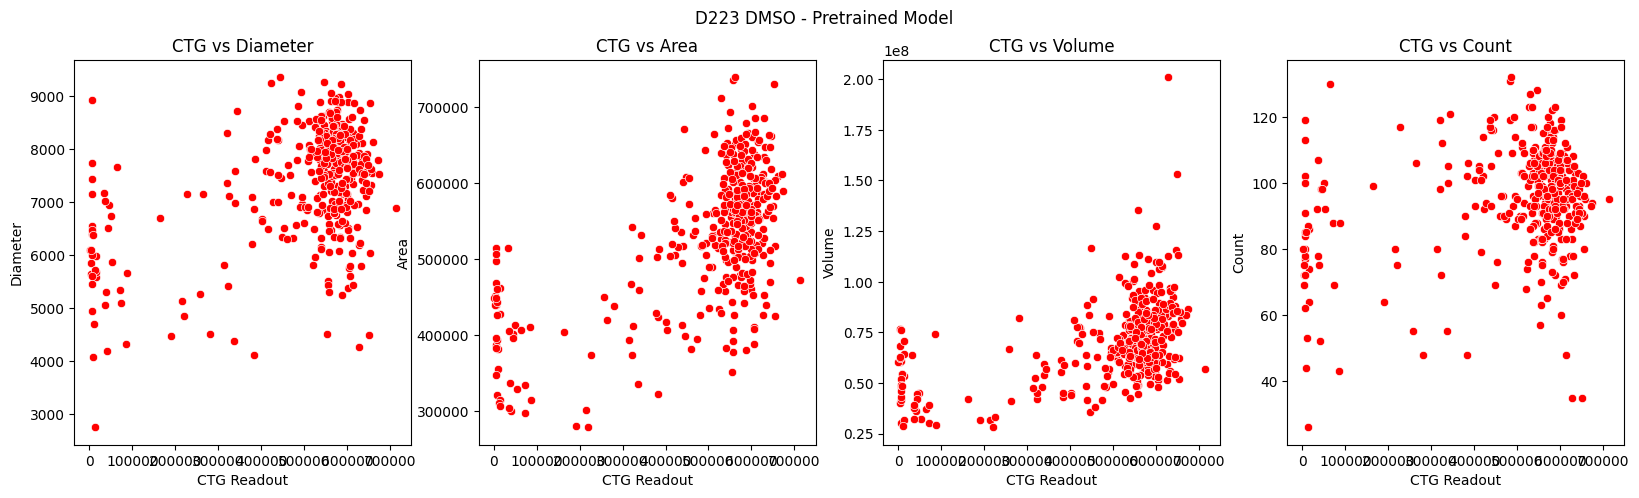

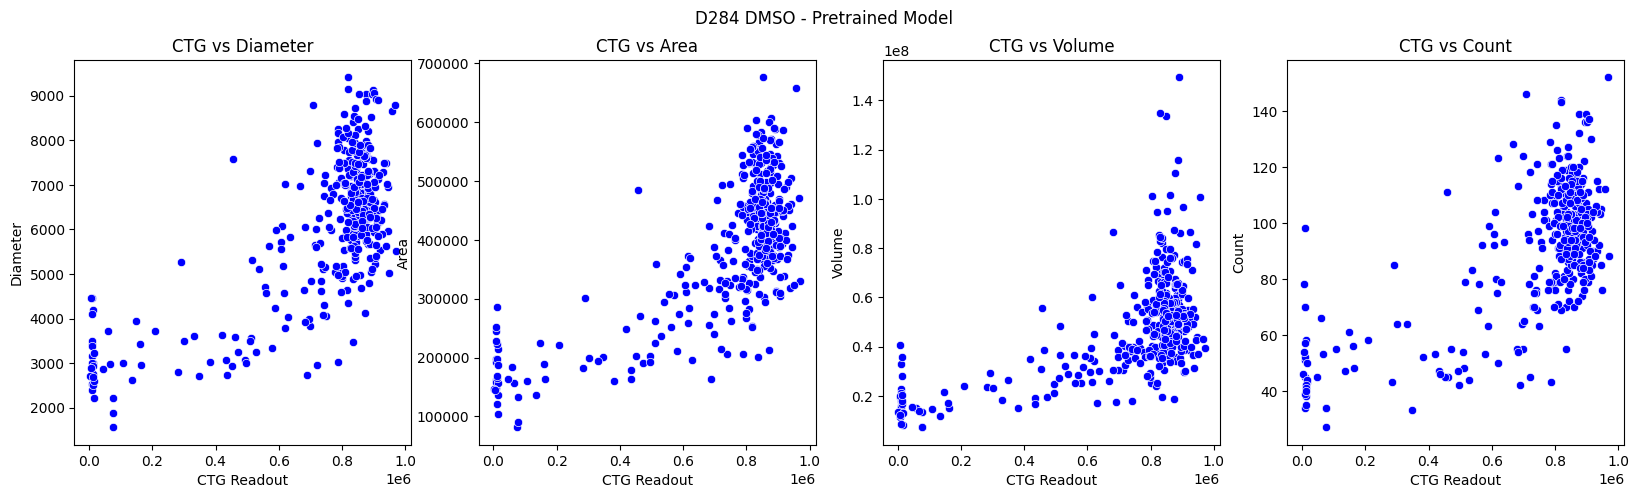

In [51]:
#plot correlation plots (ctg vs diam, area, volue) foe each experiment

conf_threshold = 0.5
features_d223_p = plot_line(processed_predictions_d223_p, ctg_values_d223, conf_threshold, "D223 DMSO - Pretrained Model", 'r')
features_d284_p = plot_line(processed_predictions_d284_p, ctg_values_d284, conf_threshold, "D284 DMSO - Pretrained Model", 'b')


## Finetuned model

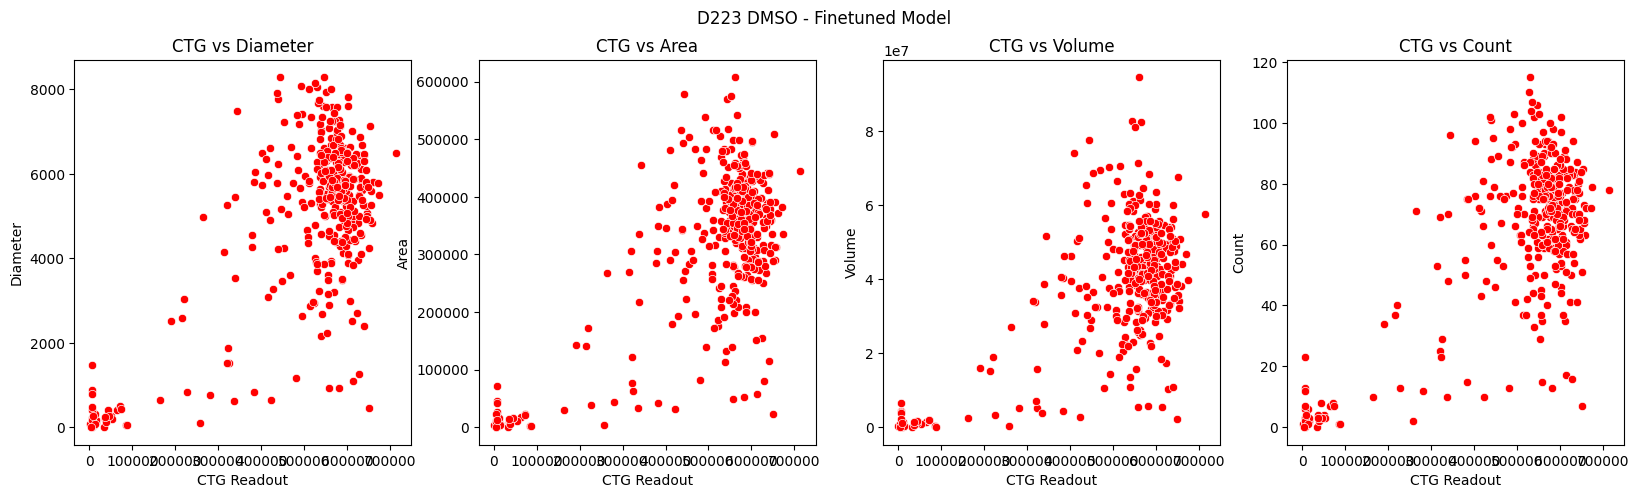

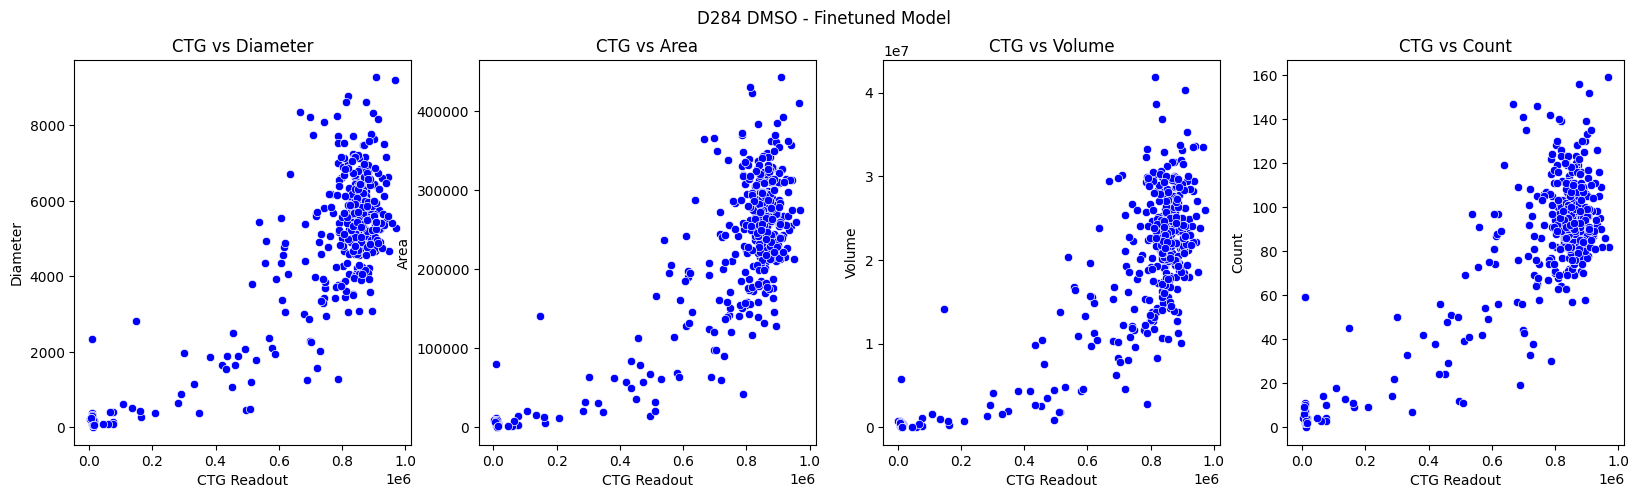

In [52]:
features_d223_f = plot_line(processed_predictions_d223_f, ctg_values_d223, conf_threshold, "D223 DMSO - Finetuned Model", 'r')
features_d284_f = plot_line(processed_predictions_d284_f, ctg_values_d284, conf_threshold, "D284 DMSO - Finetuned Model", 'b')


## Display predictions

In [38]:
features_d223_p.sort_values(by="ctg_area_diff", ascending=False, inplace=True)
features_d284_p.sort_values(by="ctg_area_diff", ascending=False, inplace=True)
features_d223_f.sort_values(by="ctg_area_diff", ascending=False, inplace=True)
features_d284_f.sort_values(by="ctg_area_diff", ascending=False, inplace=True)


## Pretrained model

CTG = 12320 (norm: 0.01268781989886819), Area = 286510.0 (norm: 0.4235995091444032)


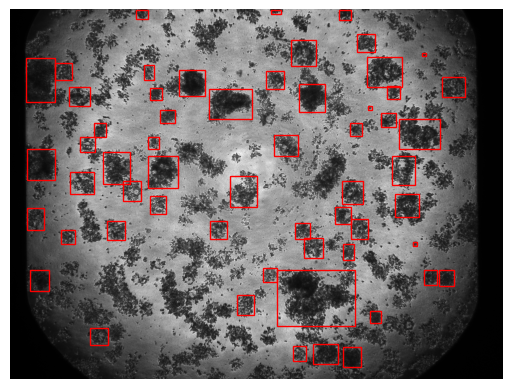

CTG = 872560 (norm: 0.8986107249152944), Area = 213375.0 (norm: 0.3154708221831246)


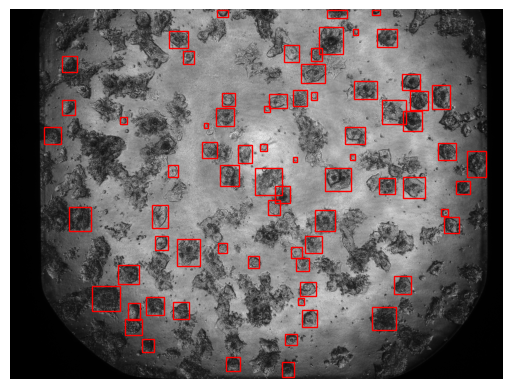

In [39]:
from skimage import io
import matplotlib.patches as patches
import numpy as np

def plot_predictions(img_path, preds):
    fig, ax = plt.subplots()
    img = io.imread(img_path)
    ax.imshow(img, cmap="gray")
    for _, row in preds.iterrows():
        if row["confidence"] > conf_threshold:
            x1, y1, x2, y2 = row[["x1", "y1", "x2", "y2"]]
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor="r", facecolor="none")
            ax.add_patch(rect)
    ax.axis("off")
    plt.show()

idx = 0
img_path = features_d284_p.iloc[idx]["path"]
preds = processed_predictions_d284_p[img_path]
print(f'CTG = {features_d284_p["ctg"].iloc[idx]} (norm: {features_d284_p["ctg_norm"].iloc[idx]}), Area = {features_d284_p["area"].iloc[idx]} (norm: {features_d284_p["area_norm"].iloc[idx]})')

plot_predictions(img_path, preds)

idx = -1
img_path = features_d284_p.iloc[idx]["path"]
preds = processed_predictions_d284_p[img_path]
print(f'CTG = {features_d284_p["ctg"].iloc[idx]} (norm: {features_d284_p["ctg_norm"].iloc[idx]}), Area = {features_d284_p["area"].iloc[idx]} (norm: {features_d284_p["area_norm"].iloc[idx]})')
plot_predictions(img_path, preds)

## Finetuned Model

D284 DMSO - Finetuned Model
CTG = 818850 (norm: 0.8432971854048877), Area = 116341.0 (norm: 0.26278567588689966)


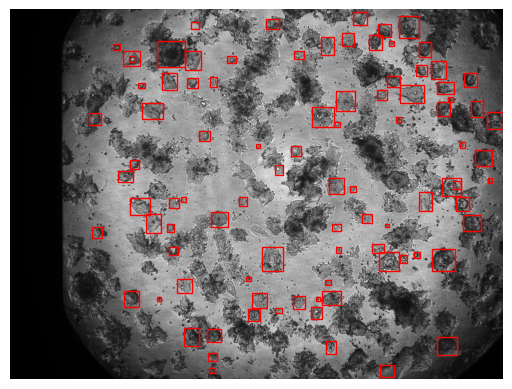

CTG = 854760 (norm: 0.8802792968146569), Area = 131447.0 (norm: 0.29690641079503616)


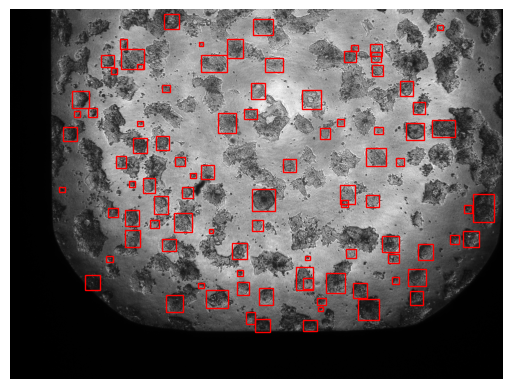

CTG = 887640 (norm: 0.9141409460252726), Area = 145845.0 (norm: 0.3294279480125225)


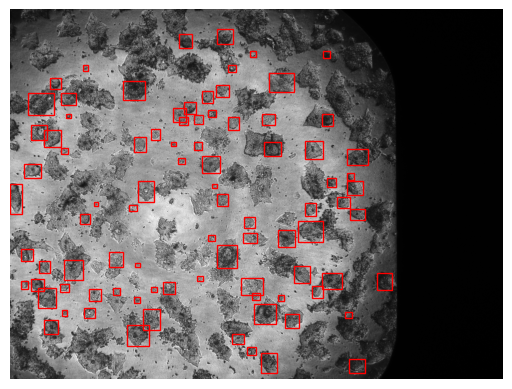

CTG = 720330 (norm: 0.741835820434393), Area = 59758.0 (norm: 0.13497860960151065)


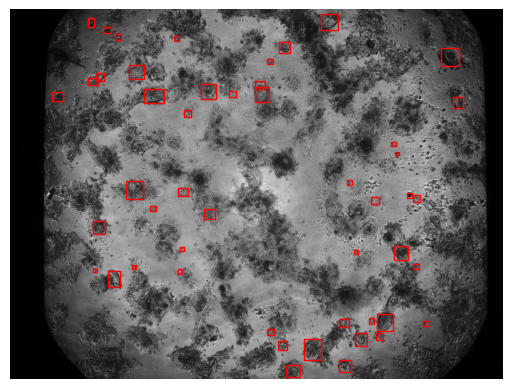

CTG = 895050 (norm: 0.9217721753637964), Area = 127500.0 (norm: 0.2879911095450418)


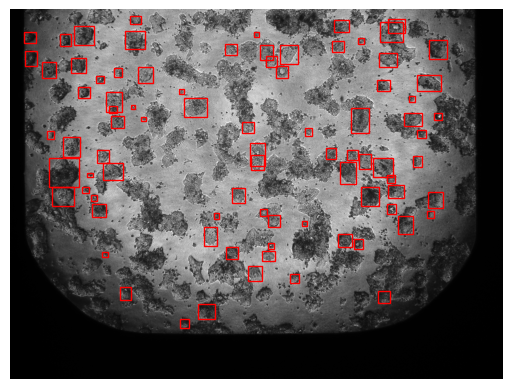

CTG = 788820 (norm: 0.8123706244013965), Area = 42540.0 (norm: 0.09608738666702807)


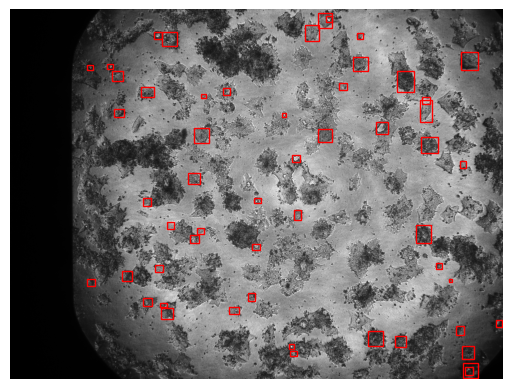

D223 DMSO - Finetuned Model
CTG = 557960 (norm: 0.7814128060052659), Area = 49700.0 (norm: 0.08179306190763802)


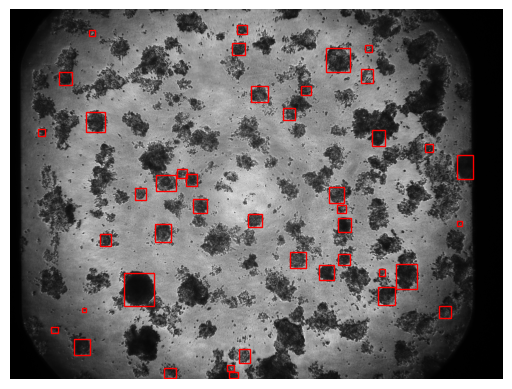

CTG = 639810 (norm: 0.8960422385300544), Area = 114895.0 (norm: 0.18908679774402556)


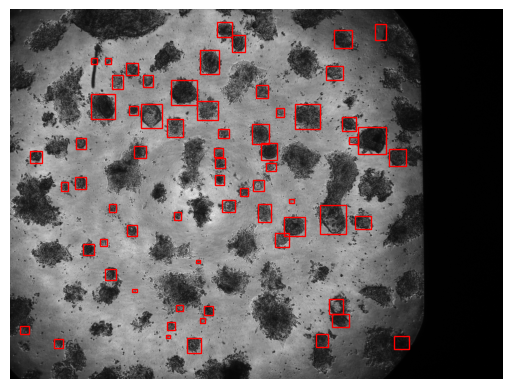

CTG = 581980 (norm: 0.8150523780180382), Area = 52365.0 (norm: 0.08617894742039166)


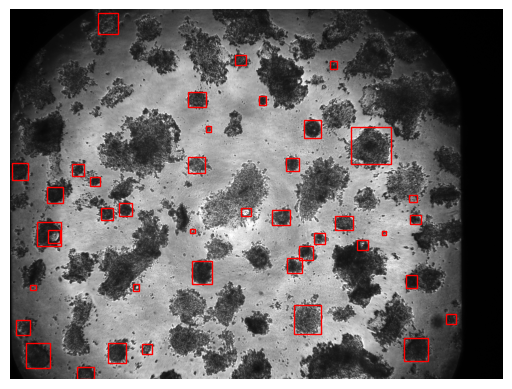

CTG = 628240 (norm: 0.8798386645005882), Area = 80145.0 (norm: 0.13189748383476155)


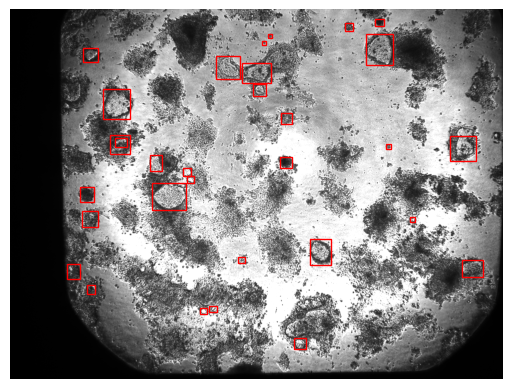

CTG = 613530 (norm: 0.859237577726738), Area = 56814.0 (norm: 0.0935008253364295)


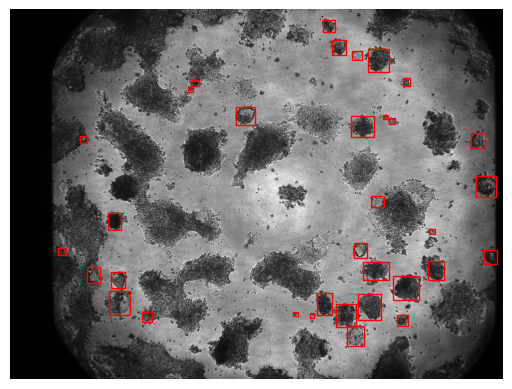

CTG = 650010 (norm: 0.9103271525404739), Area = 22625.0 (norm: 0.03723476912797405)


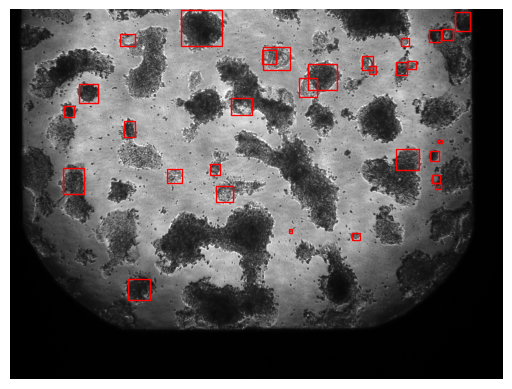

In [49]:
from skimage import io
import matplotlib.patches as patches
import numpy as np

def plot_predictions(img_path, preds):
    fig, ax = plt.subplots()
    img = io.imread(img_path)
    ax.imshow(img, cmap="gray")
    for _, row in preds.iterrows():
        x1, y1, x2, y2 = row[["x1", "y1", "x2", "y2"]]
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor="r", facecolor="none")
        ax.add_patch(rect)
    ax.axis("off")
    plt.show()

idx = [-6, -5, -4,-3,-2,-1]
print("D284 DMSO - Finetuned Model")
for i in idx:
    img_path = features_d284_f.iloc[i]["path"]
    preds = processed_predictions_d284_f[img_path]
    print(f'CTG = {features_d284_f["ctg"].iloc[i]} (norm: {features_d284_f["ctg_norm"].iloc[i]}), Area = {features_d284_f["area"].iloc[i]} (norm: {features_d284_f["area_norm"].iloc[i]})')
    plot_predictions(img_path, preds)

idx =[-6, -5, -4,-3,-2,-1]
print("D223 DMSO - Finetuned Model")
for i in idx:
    img_path = features_d223_f.iloc[i]["path"]
    preds = processed_predictions_d223_f[img_path]
    print(f'CTG = {features_d223_f["ctg"].iloc[i]} (norm: {features_d223_f["ctg_norm"].iloc[i]}), Area = {features_d223_f["area"].iloc[i]} (norm: {features_d223_f["area_norm"].iloc[i]})')
    plot_predictions(img_path, preds)


In [53]:
# dataset = MaskRCNNDataset(dataset_path="../dataset/train", datatype="eval")
# for image, targets in dataset:
#     fig, ax = plt.subplots()
#     ax.imshow(image.permute(1, 2, 0))
#     for box in targets["boxes"]:
#         x1, y1, x2, y2 = box
#         rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor="r", facecolor="none")
#         ax.add_patch(rect)
#     ax.axis("off")
#     plt.show()